In [1]:
import pandas as pd
import numpy as np
from matplotlib import use
use('Agg')
%matplotlib inline 
import matplotlib.pyplot as plt
from scipy.linalg import solve_sylvester
plt.rc('font', size = '16')

In [2]:
HiSeq = pd.read_csv('/path/to/mHSC_plate1HiSeq_counts_IndexInfo.csv', index_col=0, sep=' ')
NextSeq = pd.read_csv('/path/to/mHSC_plate1NextSeq_counts_IndexInfo.csv', index_col=0, sep=' ')

In [3]:
HiSeq = HiSeq.sort_values(by=['S.index.name','N.index.name'], ascending=[False, True])
NextSeq = NextSeq.sort_values(by=['S.index.name','N.index.name'], ascending=[False, True])

# HiSeq Reads (with signal spreading)

/mnt/kauffman/nbserver/jupyter-run-software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


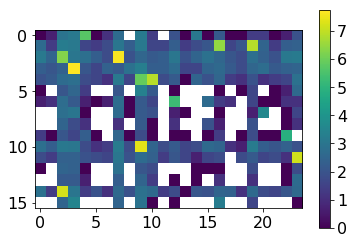

In [4]:
plt.imshow(np.log(np.array(HiSeq['Ccna2']).reshape(16,24)), cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.show()

# NextSeq Reads (no signal spreading)

/mnt/kauffman/nbserver/jupyter-run-software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


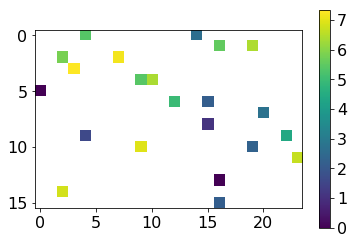

In [5]:
plt.imshow(np.log(np.array(NextSeq['Ccna2']).reshape(16,24)), cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.show()

# Modeling the spread along columns and rows

In [6]:
row_spread = np.zeros((24,24))
column_spread = np.zeros((16,16))

In [7]:
column_spread[:,:] = 0.01
row_spread[:,:] = 0.01

In [8]:
np.fill_diagonal(column_spread, 0.5)
np.fill_diagonal(row_spread, 0.5)

In [9]:
# Adjust reads and round to closest integer
adjusted_reads = np.rint(solve_sylvester(column_spread,row_spread,np.array(HiSeq['Ccna2']).reshape(16,24)))

In [10]:
# A lower bound cutoff removes false positives (unfortunately also remove true reads with low counts in that cell)
adjusted_reads[adjusted_reads < 5] = 0

# Adjusted HiSeq Reads (true signal recovered)

/mnt/kauffman/nbserver/jupyter-run-software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


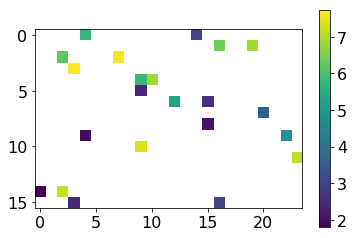

In [11]:
plt.imshow(np.log(adjusted_reads), cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.show()

In [12]:
def adjust_reads(mat, column_spread = column_spread, row_spread = row_spread):
    mat = np.array(mat).flatten()
    mat = mat.reshape(16,24)
    adjusted_reads = np.rint(solve_sylvester(column_spread,row_spread,mat))
    # A lower bound cutoff removes false positives (unfortunately also remove true reads with low counts in that cell)
    adjusted_reads[adjusted_reads < 5] = 0
    return adjusted_reads

In [13]:
adj_list = []
for i, col in HiSeq.ix[:,2:].items():
    adj_list.append(adjust_reads(col).flatten())

/mnt/kauffman/nbserver/jupyter-run-software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [14]:
true_list = []
for i, col in NextSeq.ix[:,2:].items():
    true_list.append(np.array(col))

/mnt/kauffman/nbserver/jupyter-run-software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [15]:
spread_list = []
for i, col in HiSeq.ix[:,2:].items():
    spread_list.append(np.array(col))

In [16]:
def calc_diff(arr1, arr2):
    if np.sum(np.array(arr1)) == 0:
        return np.nan
    else:
        return np.mean((np.array(arr1) == 0)  & (np.array(arr2) > 0))

In [17]:
def calc_fp(arr1, arr2):
    if np.sum(np.array(arr1)) == 0:
        return np.nan
    else:
        return np.int_(((np.array(arr1) == 0)  & (np.array(arr2) > 0)))

In [18]:
def calc_diff_2(arr1, arr2):
    if np.sum(np.array(arr1)) == 0:
        return np.nan
    else:
        return np.mean((np.array(arr1) > 0)  & (np.array(arr2) == 0))

In [19]:
adj_diff = np.array([])
spread_diff = np.array([])
for true, adj, spread in zip(true_list, adj_list, spread_list):
    adj_diff = np.append(adj_diff, calc_diff(true,adj))
    spread_diff = np.append(spread_diff, calc_diff(true,spread))
diff = adj_diff/spread_diff

/mnt/kauffman/nbserver/jupyter-run-software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [20]:
adj_fp = np.zeros(384)
spread_fp = np.zeros(384)
only_cutoff_fp = np.zeros(384)
for true, adj, spread in zip(true_list, adj_list, spread_list):
        adj_fp = adj_fp + calc_fp(true, adj)
        spread_fp = spread_fp + calc_fp(true,spread)

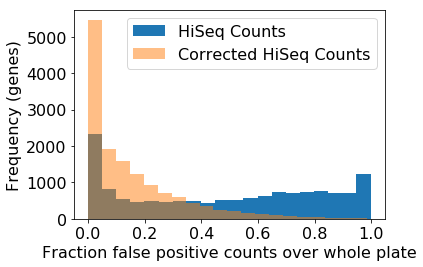

In [21]:
plt.hist(spread_diff[~np.isnan(spread_diff)], bins = 20, label = 'HiSeq Counts')
plt.hist(adj_diff[~np.isnan(adj_diff)], alpha = 0.5, bins = 20, label = 'Corrected HiSeq Counts')
#plt.title('Adjustment over all genes')
plt.xlabel('Fraction false positive counts over whole plate')
plt.ylabel('Frequency (genes)')
plt.legend()
plt.tight_layout()
plt.savefig('false_pos_spread_adj.pdf')

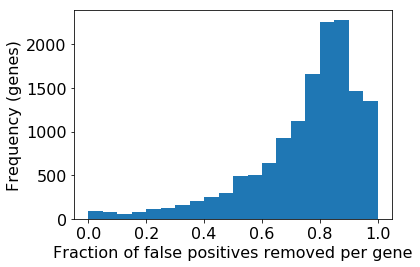

In [22]:
plt.hist(1-diff[~np.isnan(diff)], bins = 20)
#plt.title('Adjustment over all genes')
plt.xlabel('Fraction of false positives removed per gene')
plt.ylabel('Frequency (genes)')
plt.tight_layout()
plt.savefig('fraction_false_pos_spread_adj.pdf')

In [23]:
adj_diff_2 = np.array([])
spread_diff_2 = np.array([])
for true, adj, spread in zip(true_list, adj_list, spread_list):
    adj_diff_2 = np.append(adj_diff_2, calc_diff_2(true,adj))
    spread_diff_2 = np.append(spread_diff_2, calc_diff_2(true,spread))
diff_2 = adj_diff_2/(adj_diff_2+spread_diff_2)

/mnt/kauffman/nbserver/jupyter-run-software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


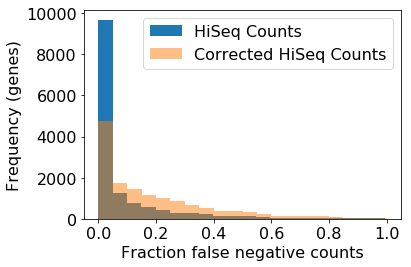

In [24]:
plt.hist(spread_diff_2[~np.isnan(spread_diff_2)], bins = 20, label = 'HiSeq Counts')
plt.hist(adj_diff_2[~np.isnan(adj_diff_2)], alpha = 0.5, bins = 20, label = 'Corrected HiSeq Counts')
plt.legend()
plt.xlabel('Fraction false negative counts')
plt.ylabel('Frequency (genes)')
plt.tight_layout()
plt.savefig('false_neg_spread_adj.pdf')

/mnt/kauffman/nbserver/jupyter-run-software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/mnt/kauffman/nbserver/jupyter-run-software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/mnt/kauffman/nbserver/jupyter-run-software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


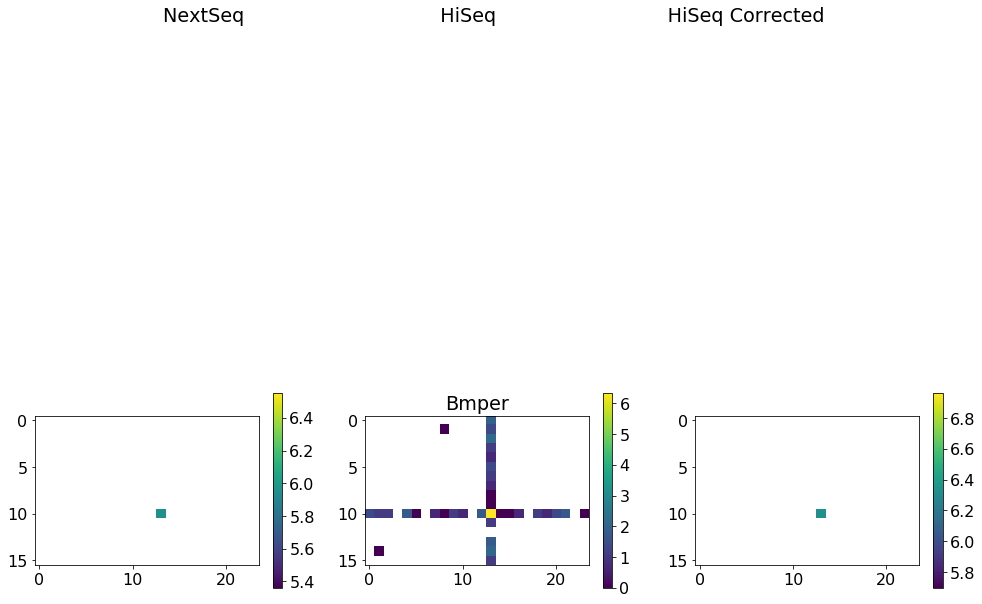

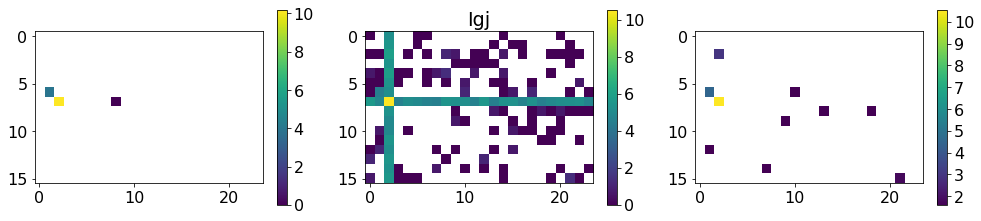

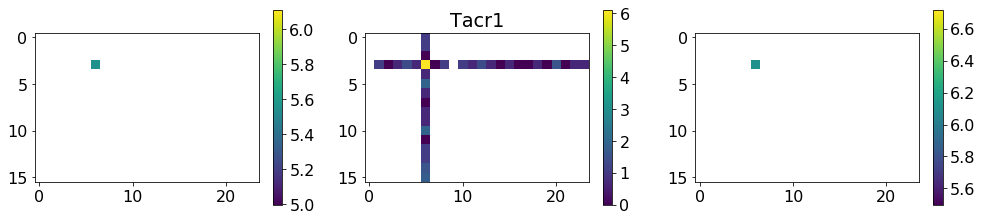

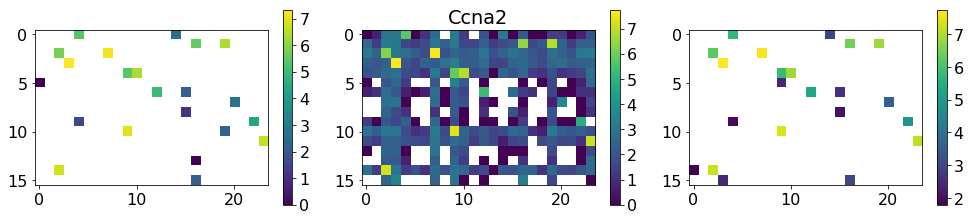

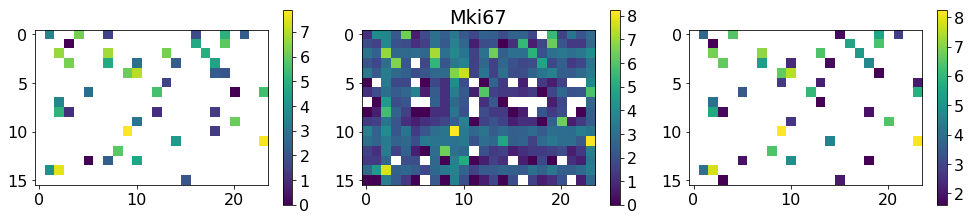

In [25]:
for gene in ['Bmper','Igj','Tacr1','Ccna2','Mki67']:     
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14,14))
    if gene == 'Bmper':
        f.suptitle('NextSeq                                HiSeq                            HiSeq Corrected')
    ax2.set_title(gene)
    im1 = ax1.imshow(np.log(np.array(NextSeq[gene]).reshape(16,24)), cmap='viridis', interpolation='nearest')
    f.colorbar(im1, ax=ax1, shrink=0.2)
    im2 = ax2.imshow(np.log(np.array(HiSeq[gene]).reshape(16,24)), cmap='viridis', interpolation='nearest')
    f.colorbar(im2, ax=ax2, shrink=0.2)
    adjusted_reads = adjust_reads(HiSeq[gene])
    im3 = ax3.imshow(np.log(adjusted_reads), cmap='viridis', interpolation='nearest')
    f.colorbar(im3, ax=ax3, shrink=0.2)
    f.tight_layout()
    plt.savefig('Adjustment_' + gene + '.pdf')